In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import grad

from pickle import dump, load

from Heston_NN import Net,weights_init

In [2]:
save_net = True
#save_net = False
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
arbitrage_weight = [1e-3,1e-3]; 
l2_weight = 1e-5
arbitrage_weight = [0.0,0.0]; 
#l2_weight = 0.0


In [3]:
table = pd.read_csv('Heston_data_input')
X = table.drop(['C_price','delta'], axis=1)
y = table[['C_price']]
#X = df[['k','T','C_price']]
#y = df[['v0','rho','kappa','theta','sigma']]
T_loc = list(X.columns).index('T')
k_loc = list(X.columns).index('k') # log strike 
X

,k,T,v0,rho,kappa,theta,sigma
0,-0.2,1.0,0.316228,-1.000000,0.001,0.001,0.001
1,-0.2,1.0,0.316228,-0.714286,0.001,0.001,0.001
2,-0.2,1.0,0.316228,-0.428571,0.001,0.001,0.001
3,-0.2,1.0,0.316228,-0.142857,0.001,0.001,0.001
4,-0.2,1.0,0.316228,0.142857,0.001,0.001,0.001
...,...,...,...,...,...,...,...
5681,0.2,1.0,0.415440,1.000000,20.000,10.000,14.286
5682,0.2,1.0,0.448511,1.000000,20.000,10.000,14.286
5683,0.2,1.0,0.481581,1.000000,20.000,10.000,14.286
5684,0.2,1.0,0.514652,1.000000,20.000,10.000,14.286


In [4]:
table.describe()

,k,T,v0,rho,kappa,theta,sigma,C_price,delta
count,5686.000000,5686.0,5686.000000,5686.000000,5686.000000,5686.000000,5686.000000,5686.000000,5686.000000
mean,0.006723,1.0,0.431894,0.268730,6.065719,4.605333,4.011151,0.240721,0.617825
std,0.130813,0.0,0.075799,0.783798,7.585582,2.863153,5.019007,0.160363,0.412394
min,-0.200000,1.0,0.316228,-1.000000,0.001000,0.001000,0.001000,0.001001,0.001640
25%,-0.085714,1.0,0.349298,-0.428571,0.001000,1.429429,0.001000,0.042445,0.073567
50%,0.028571,1.0,0.415440,0.428571,0.001000,4.286286,0.001000,0.289540,0.834684
75%,0.142857,1.0,0.481581,1.000000,11.429000,7.143143,8.572000,0.372752,0.954826
max,0.200000,1.0,0.547723,1.000000,20.000000,10.000000,14.286000,0.499876,1.140729


In [5]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
...     X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
...     X_train_val, y_train_val, test_size=0.5, random_state=42)


input_scaler = preprocessing.MinMaxScaler()
X_train_scaled = input_scaler.fit_transform(X_train)
X_val_scaled = input_scaler.transform(X_val)
X_test_scaled = input_scaler.transform(X_test)

#X_train_scaled = torch.FloatTensor(X_train_scaled,requires_grad=True)
#X_test_scaled = torch.FloatTensor(X_test_scaled,requires_grad=True)
X_train_scaled = torch.FloatTensor(X_train_scaled).to(device)
X_train_scaled.requires_grad = True
X_val_scaled = torch.FloatTensor(X_val_scaled).to(device)
X_val_scaled.requires_grad = True
X_test_scaled = torch.FloatTensor(X_test_scaled).to(device)
X_test_scaled.requires_grad = True

y_train = torch.FloatTensor(y_train.values).to(device)
y_val = torch.FloatTensor(y_val.values).to(device)
y_test = torch.FloatTensor(y_test.values).to(device)

if save_net:
    dump(input_scaler, open('input_scaler.pkl', 'wb'))
#    input_scaler = load(open('input_scaler.pkl', 'rb'))

In [6]:
input_scaler.scale_

array([2.5       , 1.        , 4.31975162, 0.5       , 0.0500025 ,
       0.10001   , 0.0700035 ])

In [7]:
input_scaler.min_

array([ 5.00000000e-01, -1.00000000e+00, -1.36602540e+00,  5.00000000e-01,
       -5.00025001e-05, -1.00010001e-04, -7.00035002e-05])

In [8]:
model = Net(num_neurons=128,device=device)
model.apply(weights_init)
#model.load_state_dict(torch.load('heston_NN_intermediate')) # load model
#model.load_state_dict(torch.load('heston_NN_final')) # load model

print(model)

Net(
  (fc1): Linear(in_features=7, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=128, bias=True)
  (fc7): Linear(in_features=128, out_features=1, bias=True)
)


# Training

In [9]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-3) # 16
#optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3) # 32
#optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-3) 
epochs = 100001
#epochs = 2001
loss_arr = []
val_arr =[]
freq = 500

for i in range(epochs):
    if i % freq == 0:
        print('Epoch: ',i,' ')
        show_log = True
        if save_net: 
            torch.save(model.state_dict(), "heston_NN_intermediate") # save the model
    else:
        show_log = False
 
#    loss = model.get_loss(X_train_scaled, y_train, T_loc, k_loc, criterion, arbitrage_weight, l2_weight, show_log=show_log)
#    val_loss = model.get_loss(X_val_scaled, y_val, T_loc, k_loc, criterion, arbitrage_weight, l2_weight, show_log=show_log)
    loss = model.get_loss_test(X_train_scaled, y_train, T_loc, k_loc, criterion, arbitrage_weight, l2_weight, show_log=show_log)
    val_loss = model.get_loss_test(X_val_scaled, y_val, T_loc, k_loc, criterion, arbitrage_weight, l2_weight, show_log=show_log)

    optimizer.zero_grad()
    loss.backward()
    loss_arr.append(float(loss))
    val_arr.append(float(val_loss))
    optimizer.step()
    


Epoch:  0  
Loss: 0.08195436000823975
Loss: 0.08258985728025436
Epoch:  500  
Loss: 0.08195436000823975
Loss: 0.08258985728025436
Epoch:  1000  
Loss: 0.08195436000823975
Loss: 0.08258985728025436
Epoch:  1500  
Loss: 0.08195436000823975
Loss: 0.08258985728025436
Epoch:  2000  
Loss: 0.08195436000823975
Loss: 0.08258985728025436
Epoch:  2500  
Loss: 0.08195436000823975
Loss: 0.08258985728025436
Epoch:  3000  
Loss: 0.08195436000823975
Loss: 0.08258985728025436
Epoch:  3500  
Loss: 0.08195436000823975
Loss: 0.08258985728025436
Epoch:  4000  
Loss: 0.08195436000823975
Loss: 0.08258985728025436
Epoch:  4500  
Loss: 0.08195436000823975
Loss: 0.08258985728025436
Epoch:  5000  
Loss: 0.008920109830796719
Loss: 0.008906172588467598
Epoch:  5500  
Loss: 0.006620591972023249
Loss: 0.006460275035351515
Epoch:  6000  
Loss: 0.005647278856486082
Loss: 0.0054773432202637196
Epoch:  6500  
Loss: 0.00489420210942626
Loss: 0.004735976457595825
Epoch:  7000  
Loss: 0.0042472705245018005
Loss: 0.0041090

Epoch:  58000  
Loss: 0.0013345370534807444
Loss: 0.0013718499103561044
Epoch:  58500  
Loss: 0.0013343608006834984
Loss: 0.001371566904708743
Epoch:  59000  
Loss: 0.0013344944454729557
Loss: 0.0013717437395825982
Epoch:  59500  
Loss: 0.0013344797771424055
Loss: 0.0013717421097680926
Epoch:  60000  
Loss: 0.001334541360847652
Loss: 0.0013718075351789594
Epoch:  60500  
Loss: 0.0013345045736059546
Loss: 0.0013717814581468701
Epoch:  61000  
Loss: 0.0013346115592867136
Loss: 0.0013720174320042133
Epoch:  61500  
Loss: 0.0013345900224521756
Loss: 0.0013719173148274422
Epoch:  62000  
Loss: 0.00133474450558424
Loss: 0.0013722270959988236
Epoch:  62500  
Loss: 0.0013346896739676595
Loss: 0.0013721247669309378
Epoch:  63000  
Loss: 0.0013346333289518952
Loss: 0.0013720598071813583
Epoch:  63500  
Loss: 0.0013348014326766133
Loss: 0.0013723511947318912
Epoch:  64000  
Loss: 0.0013347682543098927
Loss: 0.001372243743389845
Epoch:  64500  
Loss: 0.0013347782660275698
Loss: 0.00137225468643009

KeyboardInterrupt: 

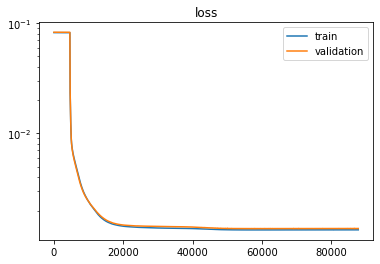

In [10]:
plt.title('loss')
plt.plot(loss_arr,label='train')
plt.plot(val_arr,label='validation')
plt.legend()
plt.yscale('log')

In [11]:
if save_net:     
    X_scaled = input_scaler.transform(X)
    X_scaled_tensor = torch.FloatTensor(X_scaled).to(device)
    y_tensor = torch.FloatTensor(table[['C_price']].values).to(device)
    model.train()
    for i in range(1000):
        loss = model.get_loss_test(X_scaled_tensor, y_tensor, T_loc, k_loc, criterion, arbitrage_weight, l2_weight, show_log=False)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(loss)
    torch.save(model.state_dict(), "heston_NN_final") # save the model

tensor(0.0014, device='cuda:0', grad_fn=<MseLossBackward>)


In [12]:
y

,C_price
0,0.381700
1,0.381703
2,0.381705
3,0.381707
4,0.381709
...,...
5681,0.011728
5682,0.011602
5683,0.011478
5684,0.011355


In [13]:
#m2 = Net()
#m2.load_state_dict(torch.load('heston_NN'))
#2.eval() # evaluation mode

# Test case

In [14]:
loss = model.get_loss(X_test_scaled, y_test, T_loc, k_loc, criterion, arbitrage_weight, l2_weight, show_log=True)

calendar  917   tensor(0., device='cuda:0', grad_fn=<AddBackward0>)
Loss: 0.0016289356863126159


# autograd

In [ ]:
x = X_train_scaled[0].clone().detach()
x.requires_grad = True
y= model.forward(x)
dydx = grad(y,x, create_graph = True)[0]

In [ ]:
if dydx[T_loc] < 0.0:
    print('nono ',torch.exp(dydx[T_loc] ))

In [ ]:
d2ydx2 = grad(dydx[T_loc],x, create_graph = True)[0]

In [ ]:
d2ydx2

In [ ]:
x = X_train_scaled.clone().detach()
x.requires_grad = True
y= model.forward(x)

In [ ]:
calendar_loss = torch.tensor(0.)
butterfly_loss = torch.tensor(0.)
for elem in X_train_scaled:
    y= model.forward(elem)
    dydx = grad(y, elem, create_graph = True)[0]
    dydT = dydx[T_loc]
    if dydT < 0.0:
        calendar_arbi_count += 1
        calendar_loss += torch.exp(-dydT[T_loc]) * 1e-1
    dydk = dydx[k_loc] # dCdk w.r.t. log-strike 
    d2ydk2 = grad(dydx[k_loc],elem, create_graph = True)[0][k_loc] # d2Cdk2 w.r.t. log-strike
    # dCdK = 1/K*dcdk
    # d2CdK2 = 1/e^2k * (d2Cdk2 - dCdk)
    # butterfly arbitrage: d2CdK2 = 1/K^2(d2Cdk2 - dCdk) > 0, d2Cdk2 > dCdk
    if d2ydk2 - dydk < 0.0: # violation of butterfly arbitrage
        butterfly_loss += torch.exp(-(d2ydk2 - dydk)) * 1e-1

In [ ]:
"""
class Net(nn.Module):

    def __init__(self,num_input=7, num_neurons=128):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(num_input, num_neurons) 
        self.fc2 = nn.Linear(num_neurons, num_neurons)
        self.fc3 = nn.Linear(num_neurons, num_neurons)
#        self.fc4 = nn.Linear(num_neurons, num_neurons)
#        self.fc5 = nn.Linear(num_neurons, num_neurons)
#        self.fc6 = nn.Linear(num_neurons, num_neurons)
        self.fc7 = nn.Linear(num_neurons, 1)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.relu(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = F.tanh(self.fc3(x))
#        x = F.relu(self.fc3(x))
#        x = F.relu(self.fc4(x))
#        x = F.relu(self.fc5(x))
#        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))
        return x
    
    def get_loss(self, x, y_train, T_loc, k_loc, criterion, arbitrage_weight, l2_weight, show_log=False):
        y_hat = self.forward(x)
        loss = criterion(y_hat, y_train)
        l2_reg = torch.tensor(0.)

        # Penalization (loop over each data)
        ## calendar arbitrage
        calendar_arbi_count = 0
        calendar_loss = torch.tensor(0.)
        butterfly_loss = torch.tensor(0.)
        for elem in x:
            y= self.forward(elem)
            dydx = grad(y, elem, create_graph = True)[0]
            dydT = dydx[T_loc]
            if dydT < 0.0:
                calendar_arbi_count += 1
                calendar_loss += torch.exp(-dydT) * arbitrage_weight[0]
        loss += calendar_loss
        ## butterfly arbitrage
        butterfly_count = 0
        dydk = dydx[k_loc] # dCdk w.r.t. log-strike 
        d2ydk2 = grad(dydx[k_loc],elem, create_graph = True)[0][k_loc] # d2Cdk2 w.r.t. log-strike
        # butterfly arbitrage: d2CdK2 = 1/K^2(d2Cdk2 - dCdk) > 0, d2Cdk2 > dCdk
        # dCdK = 1/K*dcdk
        # d2CdK2 = 1/e^2k * (d2Cdk2 - dCdk)
        butter_ineq = (d2ydk2 - dydk)/torch.exp(2.0*elem[k_loc])
        if butter_ineq < 0.0: # violation of butterfly arbitrage
            butterfly_count += 1
            butterfly_loss += torch.exp(-butter_ineq) * arbitrage_weight[1]
        loss += butterfly_loss

        # regularizations
        for param in self.parameters():
            l2_reg += torch.norm(param)
            loss += l2_lambda * l2_reg
            
        if show_log:
            if calendar_arbi_count > 0: print('calendar ',i, ' ',calendar_arbi_count,' ',calendar_loss)
            if butterfly_count > 0: print('butterfly ',i, ' ',butterfly_count,' ',butterfly_loss)
            print(f'Loss: {loss}')
            
        return loss
        

def weights_init(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
#        torch.nn.init.normal_(m.weight)
#        xavier(m.weight.data)
#        xavier(m.bias.data)

"""

In [ ]:
"""
epochs = 30001
#epochs = 101
loss_arr = []
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-3)
l2_lambda = 1e-5
criterion = nn.MSELoss()


for i in range(epochs):
    y_hat = model.forward(X_train_scaled)
    loss = criterion(y_hat, y_train)
    l2_reg = torch.tensor(0.)
    
    # Penalization (loop over each data)
    ## calendar arbitrage
    calendar_arbi_count = 0
    calendar_loss = torch.tensor(0.)
    butterfly_loss = torch.tensor(0.)
    for elem in X_train_scaled:
        y= model.forward(elem)
        dydx = grad(y, elem, create_graph = True)[0]
        dydT = dydx[T_loc]
        if dydT < 0.0:
            calendar_arbi_count += 1
            calendar_loss += torch.exp(-dydT) * 1e-1
    loss += calendar_loss
    ## butterfly arbitrage
    butterfly_count = 0
    dydk = dydx[k_loc] # dCdk w.r.t. log-strike 
    d2ydk2 = grad(dydx[k_loc],elem, create_graph = True)[0][k_loc] # d2Cdk2 w.r.t. log-strike
    # butterfly arbitrage: d2CdK2 = 1/K^2(d2Cdk2 - dCdk) > 0, d2Cdk2 > dCdk
    # dCdK = 1/K*dcdk
    # d2CdK2 = 1/e^2k * (d2Cdk2 - dCdk)
    butter_ineq = (d2ydk2 - dydk)/torch.exp(2.0*elem[k_loc])
    if butter_ineq < 0.0: # violation of butterfly arbitrage
        butterfly_count += 1
        butterfly_loss += torch.exp(-butter_ineq) * 1e-1    
    loss += butterfly_loss

    # regularizations
    for param in model.parameters():
        l2_reg += torch.norm(param)
        loss += l2_lambda * l2_reg
    loss_arr.append(loss)
    if calendar_arbi_count > 0: print('calendar ',i, ' ',calendar_arbi_count,' ',calendar_loss)
    if butterfly_count > 0: print('butterfly ',i, ' ',butterfly_count,' ',butterfly_loss)
 
    if i % 500 == 0:
        print(f'Epoch: {i} Loss: {loss}')
 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
if save_net: torch.save(model.state_dict(), "heston_NN") # save the model
"""